In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *

# Load the data

Data can be downloaded from [here](https://einstein.ai/research/the-wikitext-long-term-dependency-language-modeling-dataset). as suggested by smerity, we only add the eos flag at each end of sentence. 

In [3]:
EOS = '<eos>'
PATH=Path('../data/wikitext')

In [4]:
def read_file(filename):
    tokens = []
    with open(PATH/filename, encoding='utf8') as f:
        for line in f:
            tokens.append(line.split() + [EOS])
    return np.array(tokens)

In [5]:
trn_tok = read_file('wiki.train.tokens')
val_tok = read_file('wiki.valid.tokens')
tst_tok = read_file('wiki.test.tokens')

In [6]:
len(trn_tok), len(val_tok), len(tst_tok)

(36718, 3760, 4358)

Then we numericalize the tokens.

In [7]:
cnt = Counter(word for sent in trn_tok for word in sent)

In [8]:
cnt.most_common(10)

[('the', 113161),
 (',', 99913),
 ('.', 73388),
 ('of', 56889),
 ('<unk>', 54625),
 ('and', 50603),
 ('in', 39453),
 ('to', 39190),
 ('<eos>', 36718),
 ('a', 34237)]

In [9]:
itos = [o for o,c in cnt.most_common()]
itos.insert(0,'<pad>')

In [10]:
vocab_size = len(itos); vocab_size

33279

In [11]:
stoi = collections.defaultdict(lambda : 5, {w:i for i,w in enumerate(itos)})

In [12]:
trn_ids = np.array([([stoi[w] for w in s]) for s in trn_tok])
val_ids = np.array([([stoi[w] for w in s]) for s in val_tok])
tst_ids = np.array([([stoi[w] for w in s]) for s in tst_tok])

# Model

This is the usual AWD LSTM with three layers.

In [13]:
em_sz,nh,nl = 400,1150,3
bptt, bs = 70, 50

In [14]:
trn_dl = LanguageModelLoader(np.concatenate(trn_ids), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_ids), bs, bptt)
md = LanguageModelData(PATH, 0, vocab_size, trn_dl, val_dl, bs=bs, bptt=bptt)

In [15]:
drops_jh = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) #Jeremy's dropouts
drops_sm = np.array([0.5,0.4,0.5,0.1,0.3]) #Smerity's dropouts from the paper
drops = np.array([0.6,0.4,0.5,0.1,0.2]) #Smerity's dropouts from the github repo

Training schedule: 1cycle with either a third phase with cosine annealing or linear decay at one hundreth of the lowest lr. The second one seems to be slightly betters, but by a hair.

In [16]:
def one_cycle(steps,lr,div,max_mom,min_mom, wd):
    return [TrainingPhase(epochs=steps[0], opt_fn=optim.SGD, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR, wds=wd),
           TrainingPhase(epochs=steps[1], opt_fn=optim.SGD, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR, wds=wd),
           TrainingPhase(epochs=steps[2], opt_fn=optim.SGD, lr=lr/div, lr_decay=DecayType.COSINE, 
                          momentum=max_mom, wds=wd)]

In [17]:
def one_cycle_lin(steps,lr,div,max_mom,min_mom, wd):
    return [TrainingPhase(epochs=steps[0], opt_fn=optim.SGD, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR, wds=wd),
           TrainingPhase(epochs=steps[1], opt_fn=optim.SGD, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR, wds=wd),
           TrainingPhase(epochs=steps[2], opt_fn=optim.SGD, lr=(lr/div,lr/(div*100)), lr_decay=DecayType.LINEAR, 
                          momentum=max_mom, wds=wd)]

In [18]:
def custom_cycle(steps, lr, opt_fn, div, max_mom, min_mom, wd):
    return [TrainingPhase(steps[0], opt_fn, lr=(lr/div,lr), lr_decay=DecayType.LINEAR, 
                          momentum=(max_mom,min_mom), momentum_decay=DecayType.LINEAR, wds=wd),
            TrainingPhase(steps[1], opt_fn, lr=lr, momentum=min_mom, wds=wd),
            TrainingPhase(steps[2], opt_fn, lr=(lr,lr/div), lr_decay=DecayType.LINEAR, 
                          momentum=(min_mom,max_mom), momentum_decay=DecayType.LINEAR, wds=wd),
            TrainingPhase(steps[3], opt_fn, lr=lr/div, lr_decay=DecayType.COSINE, 
                          momentum=max_mom, wds=wd)]

Helper functions for the evaluation of the model at the end. TextReader is rewritten from the LanguageModelLoader class to have a constant bptt and only one batch.

In [19]:
class TextReader():

    def __init__(self, nums, bptt, backwards=False):
        self.bptt,self.backwards = bptt,backwards
        self.data = self.batchify(nums)
        self.i,self.iter = 0,0
        self.n = len(self.data)

    def __iter__(self):
        self.i,self.iter = 0,0
        while self.i < self.n-1 and self.iter<len(self):
            res = self.get_batch(self.i, self.bptt)
            self.i += self.bptt
            self.iter += 1
            yield res

    def __len__(self): return self.n // self.bptt 

    def batchify(self, data):
        data = np.array(data)[:,None]
        if self.backwards: data=data[::-1]
        return T(data)

    def get_batch(self, i, seq_len):
        source = self.data
        seq_len = min(seq_len, len(source) - 1 - i)
        return source[i:i+seq_len], source[i+1:i+1+seq_len].view(-1)

Validation without reinitializing the hidden state.

In [33]:
def my_validate(learn, source, bptt=2000):
    data_source = TextReader(source, bptt)
    learn.model.eval()
    learn.model.reset()
    total_loss = 0.
    for inputs, targets in tqdm(data_source):
        outputs, raws, outs = learn.model(V(inputs))
        total_loss += learn.crit(outputs, targets).detach() * targets.size(0)
    mean = total_loss / (bptt * len(data_source))
    return mean, np.exp(mean)

Cache pointer

In [21]:
def one_hot(vec, size=vocab_size):
    a = torch.zeros(len(vec), size)
    for i,v in enumerate(vec):
        a[i,v] = 1.
    return V(a)

def my_cache_pointer(model, source, theta = 0.662, lambd = 0.1279, window=200, bptt=2000):
    data_source = TextReader(source, bptt)
    model.eval()
    model.reset()
    total_loss = 0.
    targ_history = None
    hid_history = None
    for inputs, targets in tqdm(data_source):
        outputs, raws, outs = model(V(inputs))
        p_vocab = F.softmax(outputs,1)
        start = 0 if targ_history is None else targ_history.size(0)
        targ_history = one_hot(targets) if targ_history is None else torch.cat([targ_history, one_hot(targets)])
        hiddens = raws[-1].squeeze() #results of the last layer + remove the batch size.
        hid_history = hiddens if hid_history is None else torch.cat([hid_history, hiddens])
        for i, pv in enumerate(p_vocab):
            #Get the cached values
            p = pv
            if start + i > 0:
                targ_cache = targ_history[:start+i] if start + i <= window else targ_history[start+i-window:start+i]
                hid_cache = hid_history[:start+i] if start + i <= window else hid_history[start+i-window:start+i]
                all_dot_prods = torch.mv(theta * hid_cache, hiddens[i])
                exp_dot_prods = F.softmax(all_dot_prods).unsqueeze(1)
                p_cache = (exp_dot_prods.expand_as(targ_cache) * targ_cache).sum(0).squeeze()
                p = (1-lambd) * pv + lambd * p_cache
            targ_pred = p[targets[i]]
            total_loss -= torch.log(targ_pred.detach())
        targ_history = targ_history[-window:]
        hid_history = hid_history[-window:]
    mean = total_loss / (bptt * len(data_source))
    return mean, np.exp(mean)

In [52]:
class FakeLinearDecoder(nn.Module):
    #This module only applies the dropout to the last ouput but defines all the parameters we will need
    #so that they are all registered in the right layer in the learner. Everything will happen in the loss
    #as we need the targets.
    initrange=0.1
    def __init__(self, n_out, nhid, nhid_final, dropout, dropoutl, splits, K=1, tie_encoder=None):
        super().__init__()
        self.decoder = nn.Linear(nhid, n_out)
        #Dropout to apply to the output of the RNN
        self.dropout = LockedDropout(dropout)
        #Dropout to apply to the latent tensor
        self.dropoutl = LockedDropout(dropoutl)
        if tie_encoder: self.decoder.weight = tie_encoder.weight
        else: self.decoder.weight.data.uniform_(-self.initrange, self.initrange)
        #Weights to compute the prior vector
        self.prior = nn.Linear(nhid_final, K, bias=False)
        #Weights + activation to compute the latent tensor
        self.latent = nn.Sequential(nn.Linear(nhid_final, nhid * K), nn.Tanh())
        #Additional set of weights for the placeholders (new tokens that indicates the word is in another split)
        self.placeholder = nn.Linear(nhid, len(splits))

    def forward(self, input):
        raw_outputs, outputs = input
        output = self.dropout(outputs[-1])
        return output, raw_outputs, outputs

In [58]:
class MOTAS(nn.Module):
    #Mixture Of Tied Adaptive Softmaxes
    
    def __init__(self, n_out, nhid, nhid_final, splits, K, prior, latent, decoder, placeholder, dropoutl):
        super().__init__()
        self.n_out, self.nhid, self.nhid_final, self.K, self.splits = n_out, nhid, nhid_final, K, splits
        self.prior, self.latent, self.decoder, self.placeholder = prior, latent, decoder, placeholder
        self.dropoutl = dropoutl
    
    def split_on_target(self, splits, prior, latent, target):
        #Splits the prior and latent tensors dependind on where the target is in the splits.
        split_idx = torch.zeros_like(target).long()
        split_prior, split_latent, split_targ = [], [], []
        for split in splits:
            mask = (target >= split).long()
            split_idx += mask
        for idx in range(len(splits)+1):
            mask = split_idx == idx
            targ_msk = target[mask]
            split_targ.append(targ_msk)
            prior_msk = prior[mask.unsqueeze(1).expand_as(prior)]
            latent_msk = latent[mask.unsqueeze(1).expand_as(latent)]
            if targ_msk.size(0) != 0: 
                prior_msk = prior_msk.view(targ_msk.size(0),-1)
                latent_msk = latent_msk.view(targ_msk.size(0),-1)
            split_prior.append(prior_msk)
            split_latent.append(latent_msk)
        return split_prior, split_latent, split_targ

    def mix_softmax(self, pri, lat, weight, bias):
        #Computes the mix of softmaxes. The latent state goes through the relevenat part of the decoder, then
        #we average the predictions with the weights in the prior.
        lat = lat.view(-1, self.K, self.nhid)
        act = F.linear(lat, weight, bias)
        softmaxed = F.softmax(act, dim=2)
        probs = (pri.unsqueeze(2) * softmaxed).sum(dim=1)
        log_probs = torch.log(probs.add_(1e-8))
        return log_probs
        
    def log_probs(self, split_pri, split_lat):
        #First we compute the softmax of the the head + placeholders
        head_weight = torch.cat([self.decoder.weight[:self.splits[0]], self.placeholder.weight], dim=0)
        head_bias = torch.cat([self.decoder.bias[:self.splits[0]], self.placeholder.bias], dim=0)
        all_priors = torch.cat([sp for sp in split_pri if len(sp) != 0], dim=0)
        all_latents = torch.cat([sl for sl in split_lat if len(sl) != 0], dim=0)
        seps = np.array([so.size(0) for so in split_pri]).cumsum()
        head_log_probs = self.mix_softmax(all_priors, all_latents, head_weight, head_bias)
        results = [head_log_probs[:seps[0],:self.splits[0]]]
        #Then we compute separately the softmax for each split, and the prob we will send is p(placeholder) * softmax
        for i, (start, end) in enumerate(zip(self.splits, self.splits[1:] + [self.n_out])):
            if split_pri[i+1].size(0) == 0:
                results.append(split_out[i+1])
                continue
            split_log_probs = self.mix_softmax(split_pri[i+1], split_lat[i+1], 
                                               self.decoder.weight[start:end], self.decoder.bias[start:end])
            #log(p(placeholder) * softmax) = log(p(placeholder)) + log(softmax)
            results.append(split_log_probs + head_log_probs[seps[i]:seps[i+1],-len(self.splits)+i].unsqueeze(1))
        return results
    
    def forward(self, output, target):
        #Get the prior and the latent
        priors = F.softmax(self.prior(output.view(-1, self.nhid_final)), dim=1)
        latents = self.dropoutl(self.latent(output)).view(-1, self.nhid * self.K)
        split_pri, split_lat, split_targ = self.split_on_target(self.splits, priors, latents, target)
        log_probs = self.log_probs(split_pri, split_lat)
        loss, start_idx = 0, 0
        diffs = [0] + self.splits
        for diff, log_prob, targ in zip(diffs, log_probs, split_targ):
            if targ.size(0) != 0: loss += F.nll_loss(log_prob, targ - diff) * targ.size(0)
        return loss / target.size(0)

In [63]:
def get_lm_MOTAS(md, opt_fn, n_tok, emb_sz, nhid, nhid_final, nlayers, pad_token, splits, K,
                 dropout=0.4, dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5, dropoutl=0.2, qrnn=False):
    rnn_enc = RNN_Encoder(n_tok, emb_sz, nhid, nlayers, pad_token, nhid_final = nhid_final,
                 dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop, qrnn=qrnn)
    enc = rnn_enc.encoder
    m = SequentialRNN(rnn_enc, FakeLinearDecoder(n_tok, emb_sz, nhid_final, dropout, dropoutl, splits, K, enc))
    model = LanguageModel(to_gpu(m))
    m = model.model[1]
    learner = RNN_Learner(md, model, opt_fn=opt_fn)
    learner.crit = MOTAS(n_tok, emb_sz, nhid_final, splits, K, m.prior, m.latent, m.decoder, m.placeholder, m.dropoutl)
    return learner

In [25]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
splits = [2800, 20000]
learner = get_lm_MOTAS(md, opt_fn, vocab_size, em_sz, nh, nl, 0, splits, 5,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4], dropoutl=0.29)
learner.metrics = []
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

In [28]:
learner.lr_find()

 88%|████████▊ | 260/297 [00:54<00:07,  4.75it/s, loss=nan] 

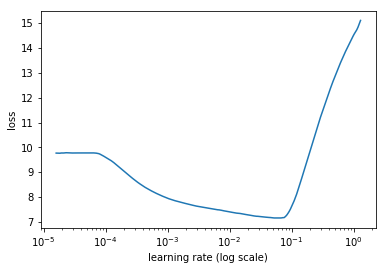

In [29]:
learner.sched.plot()

In [25]:
class SetL2WdReg(Callback):
    
    def __init__(self, learn, l2_reg, wd):
        self.learn, self.l2_reg, self.wd = learn, l2_reg, wd
    
    def on_batch_begin(self):
        for group in self.learn.sched.layer_opt.opt_params():
            group['wd'] = self.wd
            group['weight decay'] = self.l2_reg

In [27]:
wd_reg = SetL2WdReg(learner, wd, wd)

In [28]:
learner.fit_opt_sched(custom_cycle([7.5,37.5,37.5,7.5], 5e-3, opt_fn, 10, 0.8, 0.7, wd), callbacks=[wd_reg])

epoch      trn_loss   val_loss                              
    0      6.544169   6.115795  
    1      5.925789   5.56642                               
    2      5.535354   5.285057                              
    3      5.289222   5.07708                               
    4      5.129836   4.94611                               
    5      5.020651   4.858513                              
    6      4.919832   4.81441                               
    7      4.854645   4.761397                              
    8      4.807414   4.712801                              
    9      4.732497   4.676872                              
    10     4.705681   4.644085                              
    11     4.652177   4.617357                              
    12     4.612724   4.599069                              
    13     4.582318   4.591534                              
    14     4.551856   4.567731                              
    15     4.537996   4.558168                      

[4.24969143434421]

In [33]:
my_validate(learner, np.concatenate(val_ids))

 21%|██▏       | 23/108 [00:06<00:23,  3.64it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THC/generic/THCStorage.cu:58

In [26]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
splits = [2800, 20000]
learner = get_lm_MOTAS(md, opt_fn, vocab_size, em_sz, nh, nl, 0, splits, 15,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4], dropoutl=0.29)
learner.metrics = []
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

In [27]:
learner.lr_find()

 87%|████████▋ | 515/595 [01:48<00:16,  4.76it/s, loss=nan] 

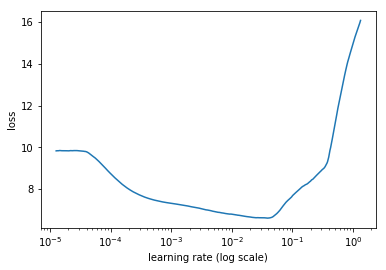

In [28]:
learner.sched.plot()

In [29]:
wd_reg = SetL2WdReg(learner, wd, wd)

In [30]:
learner.fit_opt_sched(custom_cycle([7.5,37.5,37.5,7.5], 3e-3, opt_fn, 10, 0.8, 0.7, wd), callbacks=[wd_reg])

  0%|          | 0/595 [00:00<?, ?it/s]
epoch      trn_loss   val_loss                              
    0      6.410485   6.080045  
    1      5.854744   5.554591                              
    2      5.499891   5.267295                              
    3      5.284073   5.086434                              
    4      5.124359   4.981118                              
    5      5.02161    4.889845                              
    6      4.947434   4.83225                               
    7      4.885387   4.763245                              
    8      4.807454   4.735243                              
    9      4.751681   4.680733                              
    10     4.719166   4.656826                              
    11     4.671483   4.633744                              
    12     4.64439    4.595091                              
    13     4.62636    4.592117                              
    14     4.592964   4.5714                                
    15     4

[4.253399471250864]

In [34]:
my_validate(learner, np.concatenate(val_ids))

100%|██████████| 108/108 [00:31<00:00,  3.46it/s]


(tensor(4.2479, device='cuda:0'), tensor(69.9555))

In [64]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
splits = [2800, 20000]
learner = get_lm_MOTAS(md, opt_fn, vocab_size, em_sz, nh, 650, nl, 0, splits, 5,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4], dropoutl=0.29)
learner.metrics = []
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

In [65]:
wd_reg = SetL2WdReg(learner, wd, wd)

In [ ]:
learner.fit_opt_sched(custom_cycle([7.5,37.5,37.5,7.5], 3e-3, opt_fn, 10, 0.8, 0.7, wd), callbacks=[wd_reg])

epoch      trn_loss   val_loss                              
    0      6.39829    6.022632  
 54%|█████▍    | 324/595 [00:44<00:37,  7.27it/s, loss=6.05]

In [ ]:
my_validate(learner, np.concatenate(val_ids))

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
splits = [2800, 20000]
learner = get_lm_MOTAS(md, opt_fn, vocab_size, em_sz, nh, 650, nl, 0, splits, 5,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4], dropoutl=0.2)
learner.metrics = []
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

In [ ]:
wd_reg = SetL2WdReg(learner, wd, wd)

In [ ]:
learner.fit_opt_sched(custom_cycle([7.5,37.5,37.5,7.5], 3e-3, opt_fn, 10, 0.8, 0.7, wd), callbacks=[wd_reg])

In [ ]:
my_validate(learner, np.concatenate(val_ids))

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
splits = [2800, 20000]
learner = get_lm_MOTAS(md, opt_fn, vocab_size, em_sz, nh, 650, nl, 0, splits, 15,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4], dropoutl=0.29)
learner.metrics = []
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

In [ ]:
wd_reg = SetL2WdReg(learner, wd, wd)

In [ ]:
learner.fit_opt_sched(custom_cycle([7.5,37.5,37.5,7.5], 3e-3, opt_fn, 10, 0.8, 0.7, wd), callbacks=[wd_reg])

In [ ]:
my_validate(learner, np.concatenate(val_ids))

In [ ]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
splits = [2800, 20000]
learner = get_lm_MOTAS(md, opt_fn, vocab_size, em_sz, nh, 650, nl, 0, splits, 15,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4], dropoutl=0.2)
learner.metrics = []
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

In [ ]:
wd_reg = SetL2WdReg(learner, wd, wd)

In [ ]:
learner.fit_opt_sched(custom_cycle([7.5,37.5,37.5,7.5], 3e-3, opt_fn, 10, 0.8, 0.7, wd), callbacks=[wd_reg])

In [ ]:
my_validate(learner, np.concatenate(val_ids))

Creation of the model with the best set of hyper-parameters I've found:
 - dropouts from the github repo
 - grad clipping at 0.25
 - AR and TAR loss with alpha=2 and beta=1
 - wd=1.2e-6 
Changing any one of those didn't yield better results.

In [27]:
opt_fn = partial(optim.SGD, momentum=0.95)
learner= md.get_model(opt_fn, em_sz, nh, nl,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

LR Finder

In [28]:
learner.lr_find(wds=wd, end_lr=1000)

 17%|█▋        | 51/297 [00:09<00:44,  5.55it/s, loss=10.4]
epoch      trn_loss   val_loss   accuracy                   
    0      28.393529  155.721588 0.053903  



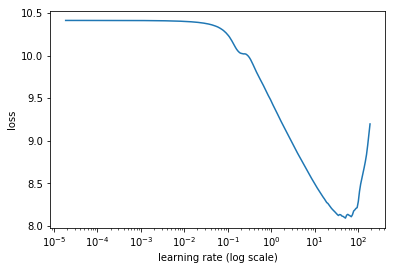

In [29]:
learner.sched.plot(10,25)

RNNs are very robust to large LRs and the gradient clipping will prevent divergence and explosion so we can take a LR near the minimum of the curve (30) (lesser values don't give as good a result). 

In [30]:
learner.fit_opt_sched(one_cycle_lin([30,30,30], 30, 10, 0.95, 0.85, wd))

epoch      trn_loss   val_loss   accuracy                   
    0      6.628112   6.184458   0.162373  
    1      6.153111   5.763566   0.19393                    
    2      5.871724   5.499626   0.218413                   
    3      5.671414   5.311994   0.226338                   
    4      5.514653   5.191954   0.2341                     
    5      5.382676   5.100694   0.237727                   
    6      5.28028    4.994971   0.245732                   
    7      5.197885   4.937758   0.248153                   
    8      5.129779   4.89894    0.24881                    
    9      5.086409   4.888917   0.246337                   
    10     5.022318   4.819836   0.254046                   
    11     4.961503   4.778642   0.257679                   
    12     4.943135   4.797901   0.251169                   
    13     4.893374   4.746737   0.257991                   
    14     4.858212   4.733589   0.257597                   
    15     4.853794   4.757826   0.256396

[4.300513040785696, 0.2911274534668408]

In [31]:
my_validate(learner.model, np.concatenate(val_ids))

100%|██████████| 108/108 [00:39<00:00,  2.75it/s]


(tensor(4.2898, device='cuda:0'), tensor(72.9502))

In [32]:
my_cache_pointer(learner.model, np.concatenate(val_ids), window=3785)

100%|██████████| 108/108 [07:50<00:00,  4.36s/it]


(tensor(4.0113, device='cuda:0'), tensor(55.2198))

Now if we go for a longer cycle...

In [33]:
opt_fn = partial(optim.SGD, momentum=0.95)
learner= md.get_model(opt_fn, em_sz, nh, nl,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1.2e-6

In [34]:
learner.fit_opt_sched(one_cycle_lin([50,50,50], 30, 10, 0.95, 0.85, wd))

epoch      trn_loss   val_loss   accuracy                   
    0      6.649408   6.197354   0.167872  
    1      6.195533   5.783183   0.200387                   
    2      5.918022   5.524694   0.215999                   
    3      5.690343   5.356249   0.22505                    
    4      5.537789   5.202367   0.233575                   
    5      5.414285   5.127078   0.235668                   
    6      5.307435   5.041664   0.23517                    
    7      5.212184   4.963502   0.246997                   
    8      5.149351   4.897415   0.248754                   
    9      5.090227   4.867299   0.251758                   
    10     5.010004   4.825522   0.254741                   
    11     4.962746   4.793763   0.256                      
    12     4.947663   4.79204    0.254782                   
    13     4.897349   4.757676   0.255848                   
    14     4.865117   4.72921    0.256547                   
    15     4.832319   4.713204   0.259961

[4.270147887631959, 0.2934068623857171]

In [35]:
my_validate(learner.model, np.concatenate(val_ids))

100%|██████████| 108/108 [00:39<00:00,  2.72it/s]


(tensor(4.2590, device='cuda:0'), tensor(70.7395))

(smerity is at 68 for the first trainign of a model)

In [36]:
my_cache_pointer(learner.model, np.concatenate(val_ids), window=3785)

100%|██████████| 108/108 [07:53<00:00,  4.39s/it]


(tensor(3.9722, device='cuda:0'), tensor(53.1025))

(smerity is at 52 for the model with cache pointer)